In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

In [ ]:
# read train data
train_df= pd.read_csv('train.csv')
#read test data
test_df = pd.read_csv('test.csv')
train_df.head()

In [ ]:
eng_train = pd.read_csv("Cache/Embeddings/bow.csv")
whole_data = pd.read_csv("Data/y_eng_oversampled.csv")
le = LabelEncoder()
eng_train['Y'] = le.fit_transform(whole_data["Sub-task A"])
train_df, test_df = train_test_split(eng_train, test_size=0.2, random_state=0)
train_df = pd.DataFrame(train_df)
test_df = pd.DataFrame(test_df)
train_df.shape, test_df.shape

In [2]:
x = pd.read_csv("Cache/Embeddings/tfidf_w2v_en.csv")
# y = pd.read_csv("Data/cleaned english.csv")["Sub-task A"]
y = pd.read_csv("Data/y_eng_oversampled.csv", header=None)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=1)
train_df=pd.DataFrame(X_train)
test_df=pd.DataFrame(X_test)

In [3]:
train_df.isna().any().any(), test_df.isna().any().any()

(False, False)

In [ ]:
train_df.drop(['Y'], axis=1, inplace=True)
test_df.drop(['Y'], axis=1, inplace=True)

In [4]:
train_df['dataset_label'] = 1
test_df['dataset_label'] = 0
combined_data = pd.concat([train_df, test_df], axis = 0)

In [5]:
def adversarial_validation(dataset, train_data, test_data):
    dataset = dataset.sample(frac=1)
    av_train = dataset[:len(train_data)]
    av_test = dataset[len(train_data):]
    return av_train, av_test
av_train, av_test = adversarial_validation(combined_data, train_df, test_df)
train_data = Pool(
    data=av_train.drop('dataset_label',1),
    label=av_train['dataset_label']
)
remaining_data = Pool(
    data=av_test.drop('dataset_label',1),
    label=av_test['dataset_label']
)
col_to_list = combined_data.columns.tolist()
col_to_list.remove('dataset_label')
metrics = {
    'iterations': 500,
    'eval_metric': 'AUC'
}
model = CatBoostClassifier(**metrics)
_ = model.fit(train_data, eval_set=remaining_data, plot=False, verbose=False)

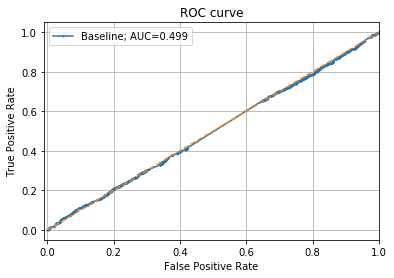

In [6]:
def rocgraph(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
rocgraph(
    [remaining_data.get_label().astype('int')],
    [model.predict_proba(remaining_data)[:,1]],
    ['Baseline']
)

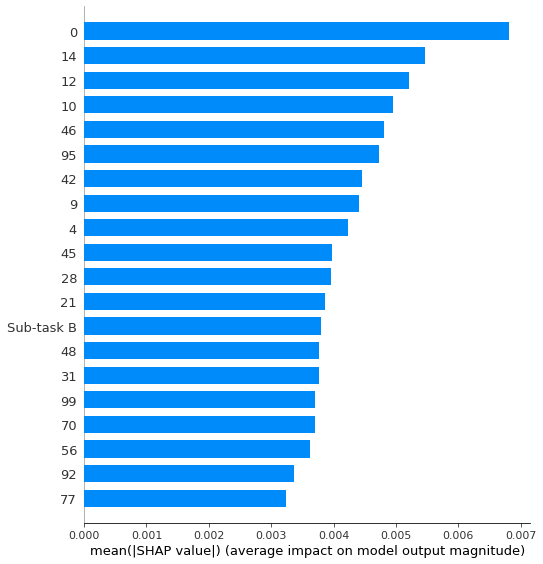

In [7]:
def plot_features(model, remaining_data, features):
    featurevalues = model.get_feature_importance(remaining_data, type='ShapValues')
    expected_value = featurevalues[0,-1]
    featurevalues = featurevalues[:,:-1]
    shap.summary_plot(featurevalues, remaining_data, feature_names=features, plot_type='bar')
plot_features(model, remaining_data, combined_data.columns)

In [8]:
train_df['Y'] = Y_train.values
train_df.drop(columns=['dataset_label'], inplace=True)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,Sub-task B,Y
10190,-0.464405,0.085329,0.173662,0.860080,0.162921,-0.741914,0.315726,-1.246204,-0.937708,0.418124,...,0.099934,-0.105449,0.455918,-0.377562,-0.310955,-0.398106,0.410669,0.241518,1,OAG
293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,NAG
12022,-0.398924,0.354351,-1.023667,1.141956,-0.187783,-0.626702,0.544659,-0.073548,-0.048320,0.490205,...,-0.334773,0.159419,-0.183133,0.007446,0.210824,-1.105538,0.216379,0.053901,1,OAG
595,0.762408,-0.334276,0.130950,0.725829,0.094326,-0.257330,0.098190,-0.804500,0.341497,-0.263209,...,0.434546,-0.284038,-0.232772,-0.507335,0.400088,0.589962,0.354255,-0.205002,1,NAG
7868,0.161286,-0.124431,-0.671367,0.730329,0.847249,-0.320956,0.256534,-0.360477,0.125937,-0.067365,...,0.287160,-0.483786,-0.508252,0.371955,-0.570179,0.065750,-0.065757,-0.693040,1,CAG


In [10]:
train_df.to_csv("Data/eng_train_tfidf_w2v.csv", index=False)

In [11]:
test_df['Y'] = Y_test.values
test_df.drop(columns=['dataset_label'], inplace=True)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,Sub-task B,Y
7003,-0.327496,-0.148566,-0.101256,-0.063605,-0.054627,0.549615,0.234779,-0.085202,-1.072566,0.296336,...,1.140229,-0.517208,-0.599617,0.142132,0.016785,0.116726,-0.028087,-0.542349,1,CAG
135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,NAG
9240,0.306826,-0.281227,-0.142893,0.509290,-0.394602,0.034082,0.309815,0.190690,-0.122837,-1.120545,...,-0.182797,-0.680128,0.117753,-0.107131,-0.313059,0.175859,0.287200,0.170213,0,OAG
9142,0.613515,-0.642675,-0.476170,0.432006,0.543010,-0.669660,0.346353,-0.535014,-0.895857,0.114008,...,0.037679,-0.976446,0.473575,0.588180,-0.410024,-0.088113,0.419565,0.273903,0,OAG
8929,-0.092922,-0.110345,-0.163128,0.580273,0.558118,-0.077599,0.166081,-0.414279,-0.683072,0.162460,...,-0.144472,-0.350767,-0.366713,0.158582,-0.401425,0.302030,-0.137532,-0.186674,1,CAG


In [12]:
test_df.to_csv("Data/eng_test_tfidf_w2v.csv", index=False)